# Fine-tuning a Small Language Model (SLM) with HuggingFace
This notebook explains how to fully fine-tune a Small Language Model (SLM) on a custom dataset with HuggingFace Transformers.

In [1]:
# !pip install trl accelerate gradio

In [2]:
import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

import trl # trl = Transformers Reinforcement Learning -> https://github.com/huggingface/trl 
import datasets 
import accelerate

import gradio as gr

import torch

from datasets import load_dataset

import json
import random


In [3]:
# Check the amount of GPU memory available (we need at least ~16GB)
if torch.cuda.is_available():
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    gpu_name = torch.cuda.get_device_name(device)
    
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    reserved_memory = torch.cuda.memory_reserved(device)
    free_memory = total_memory - reserved_memory
    
    print(f"GPU: {gpu_name}")
    print(f"Total Memory:     {total_memory / 1e6:.2f} MB | {total_memory / 1e9:.2f} GB")
    print(f"Allocated Memory: {allocated_memory / 1e6:.2f} MB | {allocated_memory / 1e9:.2f} GB")
    print(f"Reserved Memory:  {reserved_memory / 1e6:.2f} MB | {reserved_memory / 1e9:.2f} GB")
    print(f"Free Memory:      {free_memory / 1e6:.2f} MB | {free_memory / 1e9:.2f} GB")
else:
    print("No CUDA GPU available")

GPU: NVIDIA RTX A4000
Total Memory:     16750.15 MB | 16.75 GB
Allocated Memory: 0.00 MB | 0.00 GB
Reserved Memory:  0.00 MB | 0.00 GB
Free Memory:      16750.15 MB | 16.75 GB


# Setup Base Model

In [4]:
MODEL_NAME = "google/gemma-3-270m-it" # note: "it" stands for "instruction tuned" which means the model has been tuned for following instructions

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype="auto",
    device_map="auto", # put the model on the GPU
    attn_implementation="eager" # could use flash_attention_2 but ran into issues... so stick with Eager for now
)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

[INFO] Model on device: cuda:1
[INFO] Model using dtype: torch.bfloat16


In [6]:
tokenizer("Hello, how are you?")

{'input_ids': [2, 9259, 236764, 1217, 659, 611, 236881], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [7]:
outputs = model(torch.tensor(tokenizer("Hello my name is Daniel")["input_ids"]).unsqueeze(0).to(device))
outputs.keys()

odict_keys(['logits', 'past_key_values'])

## Get dataset

In [8]:
dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of samples in the dataset: {len(dataset['train'])}")

[INFO] Number of samples in the dataset: 1420


In [9]:
def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in the dataset."""
    random_idx = random.randint(0, len(dataset)-1)
    return random_idx


random_idx = get_random_idx(dataset["train"])
random_sample = dataset["train"][random_idx]

example_input = random_sample["sequence"]
example_output = random_sample["gpt-oss-120b-label"]
example_output_condensed = random_sample["gpt-oss-120b-label-condensed"]

print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example structured output (what we want our model to learn to predict):")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed (we'll train our model to predict the condensed output since it uses less tokens than JSON):")
print(example_output_condensed)

[INFO] Input:
Chicken + Vegetable Soup Nutrition Information: Serving Size 250g, Servings Per Pack 2. Energy: 748 kJ (9% Daily Intake), Protein: 13.0g (26% Daily Intake), Fat: 3.8g (5% Daily Intake), Saturated Fat: 0.8g (3% Daily Intake), Carbohydrate: 21.8g (7% Daily Intake), Sugars: 6.5g (7% Daily Intake), Dietary Fibre: 2.3g (8% Daily Intake), Sodium: 670mg (29% Daily Intake). Ingredients: Water, Pumpkin (18%), Chicken (11%), Carrots (11%), Potato (8%), Celery (7%), Brown Rice, Corn Starch, Glucose, Salt, Canola Oil, Yeast Extract, Herbs, Black Pepper. Features: Low FODMAP, Gluten Free, No Added MSG, Source of Fibre, Good Source of Protein, No Garlic or Onion, No Artificial Colours, Flavours or Preservatives. Store: Unopened in a cool dry place, refrigerate once opened in a sealed container for up to 3 days. Made in Australia from at least 97% Australian ingredients.

[INFO] Example structured output (what we want our model to learn to predict):
{'is_food_or_drink': True, 'tags': ['

In [10]:
# Our fine-tuned model will assign tags to text so we can easily filter them by type in the future
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}

## Format the dataset into LLM-style inputs/outputs

In [11]:
random_sample

{'sequence': 'Chicken + Vegetable Soup Nutrition Information: Serving Size 250g, Servings Per Pack 2. Energy: 748 kJ (9% Daily Intake), Protein: 13.0g (26% Daily Intake), Fat: 3.8g (5% Daily Intake), Saturated Fat: 0.8g (3% Daily Intake), Carbohydrate: 21.8g (7% Daily Intake), Sugars: 6.5g (7% Daily Intake), Dietary Fibre: 2.3g (8% Daily Intake), Sodium: 670mg (29% Daily Intake). Ingredients: Water, Pumpkin (18%), Chicken (11%), Carrots (11%), Potato (8%), Celery (7%), Brown Rice, Corn Starch, Glucose, Salt, Canola Oil, Yeast Extract, Herbs, Black Pepper. Features: Low FODMAP, Gluten Free, No Added MSG, Source of Fibre, Good Source of Protein, No Garlic or Onion, No Artificial Colours, Flavours or Preservatives. Store: Unopened in a cool dry place, refrigerate once opened in a sealed container for up to 3 days. Made in Australia from at least 97% Australian ingredients.',
 'image_url': None,
 'class_label': 'food',
 'source': 'manual_taken_images',
 'char_len': 868.0,
 'word_count': 13

In [12]:
def sample_to_conversation(sample):
    """Helper function to convert an input sample to conversation style."""
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user',
   'content': 'Chicken + Vegetable Soup Nutrition Information: Serving Size 250g, Servings Per Pack 2. Energy: 748 kJ (9% Daily Intake), Protein: 13.0g (26% Daily Intake), Fat: 3.8g (5% Daily Intake), Saturated Fat: 0.8g (3% Daily Intake), Carbohydrate: 21.8g (7% Daily Intake), Sugars: 6.5g (7% Daily Intake), Dietary Fibre: 2.3g (8% Daily Intake), Sodium: 670mg (29% Daily Intake). Ingredients: Water, Pumpkin (18%), Chicken (11%), Carrots (11%), Potato (8%), Celery (7%), Brown Rice, Corn Starch, Glucose, Salt, Canola Oil, Yeast Extract, Herbs, Black Pepper. Features: Low FODMAP, Gluten Free, No Added MSG, Source of Fibre, Good Source of Protein, No Garlic or Onion, No Artificial Colours, Flavours or Preservatives. Store: Unopened in a cool dry place, refrigerate once opened in a sealed container for up to 3 days. Made in Australia from at least 97% Australian ingredients.'},
  {'role': 'system',
   'content': 'food_or_drink: 1\ntags: np, il, fi\nfoods: Chi

In [13]:
# Map our sample_to_conversation function to dataset 
dataset = dataset.map(sample_to_conversation,
                      batched=False)

dataset["train"][42]

{'sequence': 'another optional quest takes place on windfall island during the night time play the song of passing a number of times and each time, glance towards the sky',
 'image_url': 'https://portforward.com/games/walkthroughs/The-Legend-of-Zelda-The-Wind-Waker/The-Legend-of-Zelda-The-Wind-Waker-large-430.jpg',
 'class_label': 'not_food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 156.0,
 'word_count': 28.0,
 'syn_or_real': 'real',
 'uuid': 'bbac79ce-df1f-48b8-891c-752809be11c7',
 'gpt-oss-120b-label': "{'is_food_or_drink': 'false', 'tags': [], 'food_items': [], 'drink_items': []}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None,
 'messages': [{'content': 'another optional quest takes place on windfall island during the night time play the song of passing a number of times and each time, glance towards the sky',
   'role': 'u

In [14]:
# Create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2,
                                            shuffle=False,
                                            seed=42)

# Number #1 rule in machine learning
# Always train on the train set and test on the test set
# This gives us an indication of how our model will perform in the real world
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

## Try the model with a pipeline


In [15]:
easy_sample = {"role": "user", 
               "content": "Hi my name is superzerosec"}

def create_easy_sample(input):
    template = {"role": "user", "content": input}
    return template

In [16]:
# Load model and use it as a pipeline
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer)

input_text = "Hi my name is superzerosec. Please reply to me with a machine learning poem."
easy_sample = create_easy_sample(input=input_text)
input_prompt = pipe.tokenizer.apply_chat_template([easy_sample], # pipeline tokenizer wants a list of inputs
                                                  tokenize=False,
                                                  add_generation_prompt=True)

print(f"[INFO] This is the input prompt: {input_prompt}")

default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {MODEL_NAME}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Device set to use cuda:1


[INFO] This is the input prompt: <bos><start_of_turn>user
Hi my name is superzerosec. Please reply to me with a machine learning poem.<end_of_turn>
<start_of_turn>model

[INFO] Input:
Hi my name is superzerosec. Please reply to me with a machine learning poem.

[INFO] Output from google/gemma-3-270m-it:

Hi Superzerosec,
I'm ready to be your machine learning poem. 



## Try the model on one of our sequences

In [17]:
# Get a random sample
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
CJ Food Andu Ginger Flavoured Dumplings Nutrition Information: Servings per package: About 2, Serving size: 129 g (6 pieces). Average Quantity per serving: Energy 1000 kJ (240 kcal), Protein 7.2 g, Fat total 14.2 g (saturated 2.7 g), Carbohydrate 21.0 g (sugars 1.2 g), Sodium 409 mg. Average Quantity per 100 g: Energy 778 kJ (186 kcal), Protein 7.2 g, Fat total 5.6 g (saturated 11.0 g), Carbohydrate 2.1 g (sugars 16.3 g), Sodium 317 mg. Ingredients: Fish Gelatin, Seasoning (Yeast Extract, Salt, Soy Sauce), Flavour Enhancer, Wheat Flour, Canola Oil, Palm Shortening, Texturized Soy, Water, Modified Tapioca Starch, Protein, Tofu, Onion, Cabbage, Ginger, Wheat Fibre, Garlic, Thickener, Spring Onion, Leek, Soy Sauce, Hot Pepper Extract, Flavour Enhancers, Salt, Sugar, Artificial Flavour, Black Pepper Powder, Ginger Powder, Seasoning, Thickener, Natural Flavour. Contains: Fish, Soy, Wheat, Gluten. May contain: Crustacean, Egg, Milk, Mollusc, Peanut, Ses

## Let’s try to prompt the model
We want a model to extract food and drink items from text.

By default the model will just reply to any text input with a generic response.

However, we can try and get our ideal outputs via prompting.

In [18]:
prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]
    
    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_train_sample)[0]["content"])

[INFO] Original content:
CJ Food Andu Ginger Flavoured Dumplings Nutrition Information: Servings per package: About 2, Serving size: 129 g (6 pieces). Average Quantity per serving: Energy 1000 kJ (240 kcal), Protein 7.2 g, Fat total 14.2 g (saturated 2.7 g), Carbohydrate 21.0 g (sugars 1.2 g), Sodium 409 mg. Average Quantity per 100 g: Energy 778 kJ (186 kcal), Protein 7.2 g, Fat total 5.6 g (saturated 11.0 g), Carbohydrate 2.1 g (sugars 16.3 g), Sodium 317 mg. Ingredients: Fish Gelatin, Seasoning (Yeast Extract, Salt, Soy Sauce), Flavour Enhancer, Wheat Flour, Canola Oil, Palm Shortening, Texturized Soy, Water, Modified Tapioca Starch, Protein, Tofu, Onion, Cabbage, Ginger, Wheat Fibre, Garlic, Thickener, Spring Onion, Leek, Soy Sauce, Hot Pepper Extract, Flavour Enhancers, Salt, Sugar, Artificial Flavour, Black Pepper Powder, Ginger Powder, Seasoning, Thickener, Natural Flavour. Contains: Fish, Soy, Wheat, Gluten. May contain: Crustacean, Egg, Milk, Mollusc, Peanut, Sesame, Tree nuts

In [19]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_train_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, 
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Return only the formatted output and nothing else.

Target input text: CJ Food Andu Ginger Flavoured Dumplings Nutrition Information: Servings per package: About 2, Serving size: 129 g (6 pieces). Average Quantity per serving: Energy 1000 kJ (240 kcal), Protein 7.2 g, Fat total 14.2 g (saturated 2.7 g), Carbohydrate 21.0 g (sugars 1.2 g), Sodium 409 mg. Average Quantity 

In [20]:
# This is our input
print(random_train_sample["messages"][0]["content"])
print()

# This is our ideal output: 
print(random_train_sample["messages"][1]["content"])

CJ Food Andu Ginger Flavoured Dumplings Nutrition Information: Servings per package: About 2, Serving size: 129 g (6 pieces). Average Quantity per serving: Energy 1000 kJ (240 kcal), Protein 7.2 g, Fat total 14.2 g (saturated 2.7 g), Carbohydrate 21.0 g (sugars 1.2 g), Sodium 409 mg. Average Quantity per 100 g: Energy 778 kJ (186 kcal), Protein 7.2 g, Fat total 5.6 g (saturated 11.0 g), Carbohydrate 2.1 g (sugars 16.3 g), Sodium 317 mg. Ingredients: Fish Gelatin, Seasoning (Yeast Extract, Salt, Soy Sauce), Flavour Enhancer, Wheat Flour, Canola Oil, Palm Shortening, Texturized Soy, Water, Modified Tapioca Starch, Protein, Tofu, Onion, Cabbage, Ginger, Wheat Fibre, Garlic, Thickener, Spring Onion, Leek, Soy Sauce, Hot Pepper Extract, Flavour Enhancers, Salt, Sugar, Artificial Flavour, Black Pepper Powder, Ginger Powder, Seasoning, Thickener, Natural Flavour. Contains: Fish, Soy, Wheat, Gluten. May contain: Crustacean, Egg, Milk, Mollusc, Peanut, Sesame, Tree nuts, Sulphites. Keep Frozen 

# Fine-tuning
Steps:

1. Setup SFTConfig (Supervised Fine-tuning Config) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTConfig
2. Use SFTTrainer to train our model on our supervised samples (from our dataset above) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer

In [21]:
# Setting up our SFTConfig
from trl import SFTConfig

torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = "./test_checkpoint_models"
BASE_LEARNING_RATE = 5e-5

print(f"[INFO] Using dtype: {torch_dtype}")
print(f"[INFO] Using learning rate: {BASE_LEARNING_RATE}")

sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=2,  # Reduced for ~12GB VRAM; use gradient_accumulation_steps to keep effective batch size
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Effective batch = 2 * 8 = 16
    gradient_checkpointing=True,    # Saves VRAM by recomputing activations in backward
    optim="adamw_torch_fused", # Note: if you try "adamw", you will get an error
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=BASE_LEARNING_RATE,
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.float16 else False,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=None
)

# There are a lot of settings in the sft_config, so feel free to uncomment this and inspect it if you want
#sft_config

[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


Config setup, now we can train our model with SFTTrainer!

In [22]:
# Supervised Fine-Tuning = provide input and desired output samples
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer 
)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,1.763800,2.144341
2,1.501100,2.158903
3,1.540200,2.217682


TrainOutput(global_step=213, training_loss=1.8454665757121054, metrics={'train_runtime': 215.1017, 'train_samples_per_second': 15.844, 'train_steps_per_second': 0.99, 'total_flos': 451193783932416.0, 'train_loss': 1.8454665757121054})

TrainOutput(global_step=213, training_loss=1.8445255733991452, metrics={'train_runtime': 320.1481, 'train_samples_per_second': 10.645, 'train_steps_per_second': 0.665, 'total_flos': 873751312465920.0, 'train_loss': 1.8445255733991452, 'epoch': 3.0})
Woohoo! Looks like our training accuracy went up.

Let’s inspect the loss curves.

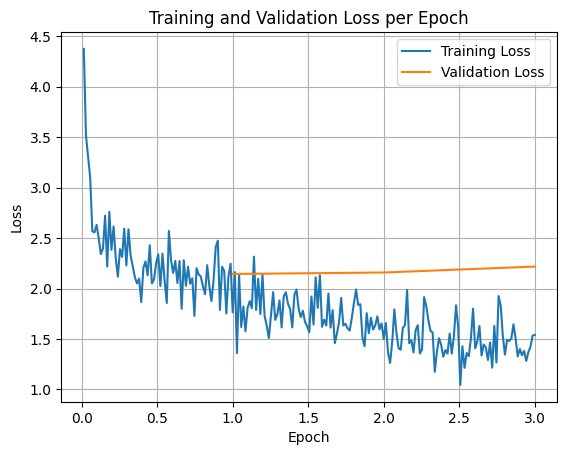

In [23]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Save the model
trainer.save_model()

In [25]:
# Remove all the checkpoint folders (since we've already saved the best model)
!rm -rf ./test_checkpoint_models/checkpoint-*

# Load the trained model back in and see how it performs
We’ve now fine-tuned our own Gemma 3 270M to do a specific task, let’s load it back in and see how it performs.

In [26]:
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=CHECKPOINT_DIR_NAME,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)

In [27]:
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

Device set to use cuda:0


In [28]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 284
})

In [29]:
# Get a random sample
random_test_idx = get_random_idx(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt, 
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
The image shows a package of "Helpful Harvest" dried vegetables. The ingredients include a variety of vegetables such as zucchini, carrots, mushrooms, onions, capsicum, and celery. The product is made from 100% vegetables and includes wonky and overly abundant produce where possible. The package notes that the ingredients and percentages may differ due to seasonal availability.

The allergens listed are milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, and almonds. The nutrition information indicates that the package contains 4 servings, with each serving size being 10g. The average quantities per serving are as follows:
- Energy: 125 kJ
- Protein: 1.9 g
- Gluten: 0 g (marked as gluten-free)
- Fat, total: 0.3 g
- Saturated fat: 0 g
- Carbohydrate: 3.4 g
- Sugars: 3.4 g
- Fibre: 3.4 g
- Sodium: 2.1 g

The average quantities per 100g are:
- Energy: 1250 kJ
- Protein: 18.7 g
- Fat, total: 2.8 g
- Saturated fat: 0 g
- Carbohydrate: 34.3 g

In [30]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fi, fp
foods: zucchini, carrots, mushrooms, onions, capsicum, celery, milk, eggs, soy, sesame seeds, hazelnuts, pistachios, cashews, almonds
drinks:


# Counting the number of parameters in our model

In [31]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


# Reference
[Hugging Face LLM Full Fine Tune Tutorial](https://www.learnhuggingface.com/notebooks/hugging_face_llm_full_fine_tune_tutorial)  
[SFTConfig](https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer)